In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xesmf as xe
import geopandas as gpd
import shapely.geometry as geom
import matplotlib as mpl
import regionmask
import cartopy.crs as ccrs
from shapely.geometry import box
import matplotlib.colors as mcolors
# plt.rcParams.update({'font.size': 14})

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'stratiform_rainfall_flux' 
da1 = 'control_d0198_RAL3P2_'
da2 = 'drysoil_d0198_RAL3P2_'

#control and SM
control = xr.open_dataset(f'{datapath}/{variable}/{da1}{variable}.nc')[variable]
SM = xr.open_dataset(f'{datapath}/{variable}/{da2}{variable}.nc')[variable]

#push to AEST
control = control.assign_coords(time=control['time'] + pd.Timedelta(hours=10))
SM = SM.assign_coords(time=SM['time'] + pd.Timedelta(hours=10))

variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{da1}{variable3}.nc')["land_binary_mask"].isel(time=0)

#clip to land only
control= control.where(landmask == 1)
SM = SM.where(landmask == 1)

In [3]:
variable2 = 'surface_altitude'
experiment2 = 'control_d0198_RAL3P2_' 
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment2}{variable2}.nc')[variable2].isel(time=0)

In [4]:
AGCD= xr.open_dataset("/g/data/ng72/as9583/stratiformrainfall/AGCD.nc")['precip']
fires = gpd.read_file('/g/data/ng72/as9583/fire/merged_fires.gpkg')

In [5]:
#clip fires to domain
lon_min = float(control.longitude.min())
lon_max = float(control.longitude.max())
lat_min = float(control.latitude.min())
lat_max = float(control.latitude.max())

model_extent = box(lon_min, lat_min, lon_max, lat_max)

fires_clipped = fires.clip(model_extent)

## SM Data

In [6]:
#soil moisture data, push to AEST and clip to land
variable_SM = 'soil_moisture_l1'
control_soil = xr.open_dataset(f'{datapath}/{variable_SM}/{da1}{variable_SM}.nc')['moisture_content_of_soil_layer']
SM_soil = xr.open_dataset(f'{datapath}/{variable_SM}/{da2}{variable_SM}.nc')['moisture_content_of_soil_layer']

control_soil = control_soil.assign_coords(time=control_soil['time'] + pd.Timedelta(hours=10))
SM_soil = SM_soil.assign_coords(time=SM_soil['time'] + pd.Timedelta(hours=10))

control_soil = control_soil.where(landmask == 1)
SM_soil = SM_soil.where(landmask == 1)

## Model on AGCD resolution

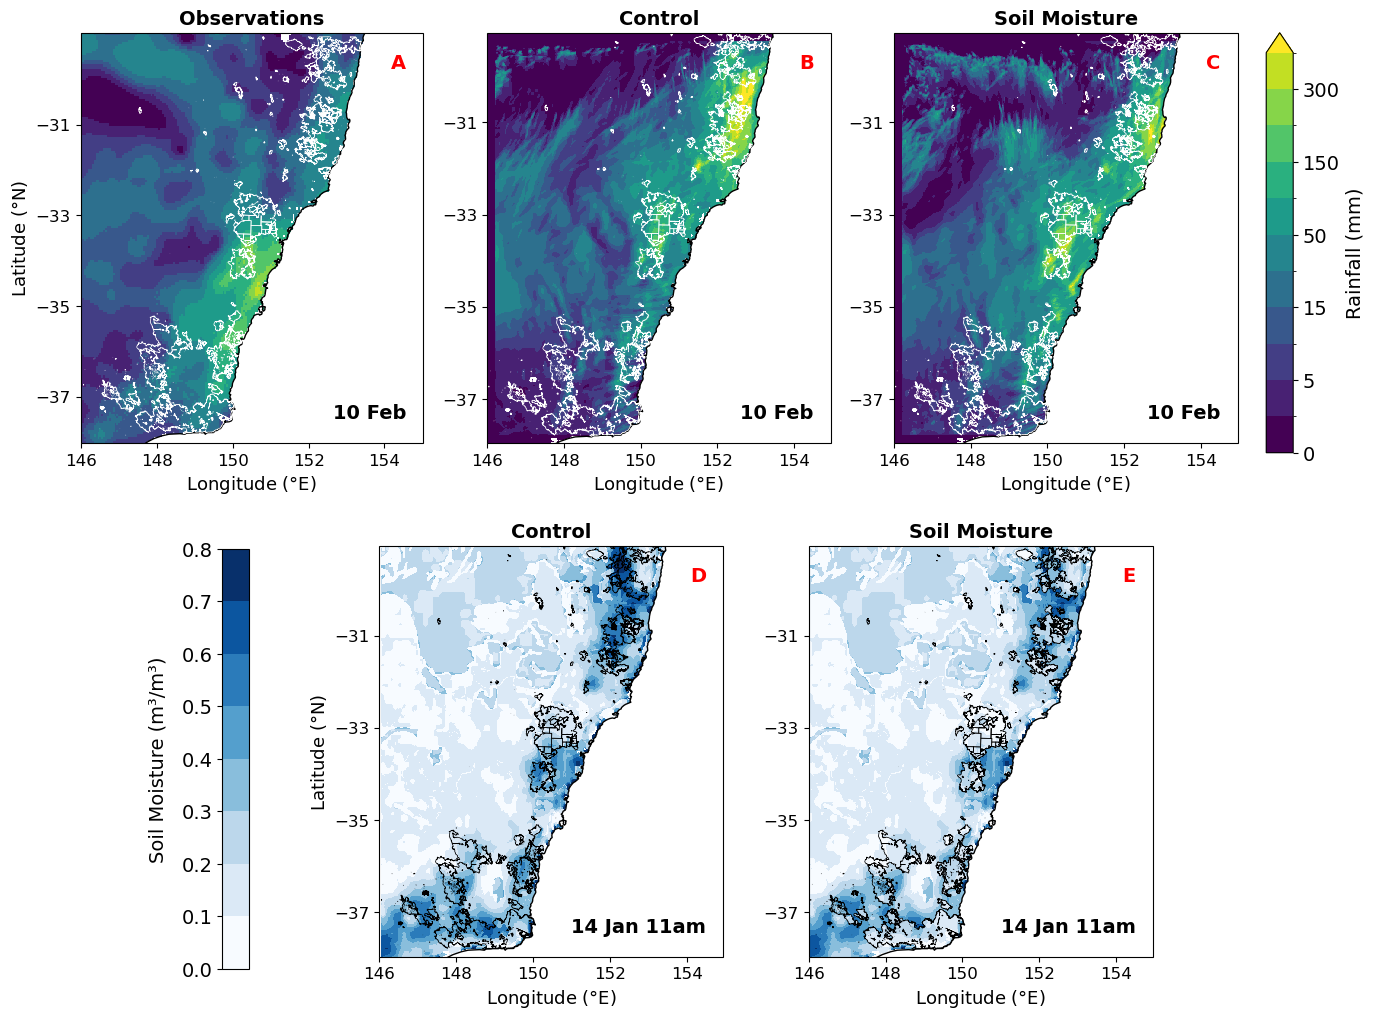

In [7]:
#feb 10
date = '2020-02-10'
day = pd.Timestamp(date)

start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
end_time = day + pd.Timedelta(hours=8)
labels = ['A', 'B', 'C', 'D', 'E']

fig = plt.figure(figsize=(18,12))
gs = fig.add_gridspec(2, 1, height_ratios=[1,1], hspace=0.25)  #rows


top_row = gs[0].subgridspec(1, 3, wspace=-0.3)
axes0 = fig.add_subplot(top_row[0], projection=ccrs.PlateCarree())  #observations
axes1 = fig.add_subplot(top_row[1], projection=ccrs.PlateCarree())  #control
axes2 = fig.add_subplot(top_row[2], projection=ccrs.PlateCarree())  #SM

bottom_row = gs[1].subgridspec(1, 5, wspace=-0.6)  #5 columns to centre
ax3 = fig.add_subplot(bottom_row[1:3], projection=ccrs.PlateCarree())  #Control SM
ax4 = fig.add_subplot(bottom_row[3:5], projection=ccrs.PlateCarree())  #SM SM


#-----rainfall----
rain_levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]
cmap_rain = "viridis"

im0 = AGCD.sel(time=date).plot(ax=axes0, cmap=cmap_rain, levels=rain_levels,
                               extend="max", add_colorbar=False)
fires_clipped.boundary.plot(ax=axes0, edgecolor="white", linewidth=0.5)
im1 = (control.sel(time=slice(start_time, end_time))*3600).sum(dim="time").where(landmask==1)\
    .plot(ax=axes1, cmap=cmap_rain, levels=rain_levels, extend="max", add_colorbar=False)
fires_clipped.boundary.plot(ax=axes1, edgecolor="white", linewidth=0.5)
im2 = (SM.sel(time=slice(start_time, end_time))*3600).sum(dim="time").where(landmask==1)\
    .plot(ax=axes2, cmap=cmap_rain, levels=rain_levels, extend="max", add_colorbar=False)
fires_clipped.boundary.plot(ax=axes2, edgecolor="white", linewidth=0.5)

for ax, title in zip([axes0, axes1, axes2], ["Observations", "Control", "Soil Moisture"]):
    ax.coastlines()
    ax.set_xticks(np.arange(146, 155, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-37, -30, 2), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=12)
    ax.set_xlabel("Longitude ($\\degree$E)", fontsize = 13)
    ax.set_ylabel("Latitude ($\\degree$N)", fontsize = 13)
    ax.set_title(title, fontsize = 14, fontweight = 'bold')
    ax.text(0.95, 0.05, '10 Feb', transform= ax.transAxes,
        fontsize=14, fontweight="bold", va="bottom", ha="right", color="black")
axes1.set_ylabel("")
axes2.set_ylabel("")


#---soil moisture---
sm_levels = np.arange(0, 0.9, 0.1)
cmap_sm = plt.get_cmap('Blues')
norm_sm = mcolors.BoundaryNorm(boundaries=sm_levels, ncolors=cmap_sm.N)

p3 = ax3.pcolormesh(control_soil.isel(time=0).longitude,
                    control_soil.isel(time=0).latitude,
                    control_soil.isel(time=0),
                    cmap=cmap_sm, norm=norm_sm,
                    transform=ccrs.PlateCarree())
ax3.set_title("Control", fontsize = 14, fontweight = 'bold')
fires_clipped.boundary.plot(ax=ax3, edgecolor="black", linewidth=0.5)

p4 = ax4.pcolormesh(SM_soil.isel(time=0).longitude,
                    SM_soil.isel(time=0).latitude,
                    SM_soil.isel(time=0),
                    cmap=cmap_sm, norm=norm_sm,
                    transform=ccrs.PlateCarree())
ax4.set_title("Soil Moisture", fontsize = 14, fontweight = 'bold')
fires_clipped.boundary.plot(ax=ax4, edgecolor="black", linewidth=0.5)


for ax in [ax3, ax4]:
    ax.coastlines()
    ax.set_xticks(np.arange(146, 155, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-37, -30, 2), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=12)
    ax.set_xlabel("Longitude ($\\degree$E)", fontsize = 13)
    ax.set_ylabel("Latitude ($\\degree$N)", fontsize = 13)
    ax.text(0.95, 0.05, '14 Jan 11am', transform= ax.transAxes,
             fontsize=14, fontweight="bold", va="bottom", ha="right", color="black")

ax4.set_ylabel("")

#---colorbars---
#cbar rain
cbar_rain_ax = fig.add_axes([0.85, 0.53, 0.015, 0.35]) 
cbar_rain = fig.colorbar(im0, cax=cbar_rain_ax, orientation='vertical')
cbar_rain.set_label("Rainfall (mm)", fontsize=14)
cbar_rain.ax.tick_params(axis='y', labelsize=14) 

#cbar soil moisture
cbar_sm_ax = fig.add_axes([0.27, 0.1, 0.015, 0.35])
cbar_sm = fig.colorbar(p4, cax=cbar_sm_ax, orientation='vertical')
cbar_sm.ax.yaxis.set_label_position("left")
cbar_sm.ax.yaxis.tick_left()   
cbar_sm.set_label("Soil Moisture (m³/m³)", rotation=90, labelpad=10, fontsize = 14)
cbar_sm.ax.tick_params(axis='y', labelsize=14) 

#adding red labels
axes = [axes0, axes1, axes2, ax3, ax4]
for ax, label in zip(axes, labels):
    ax.text(
        0.95, 0.95, 
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',    
        ha='right',   
        color='red'
    )

# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/SM_peculiarities.png', dpi = 300, bbox_inches='tight')
plt.show()


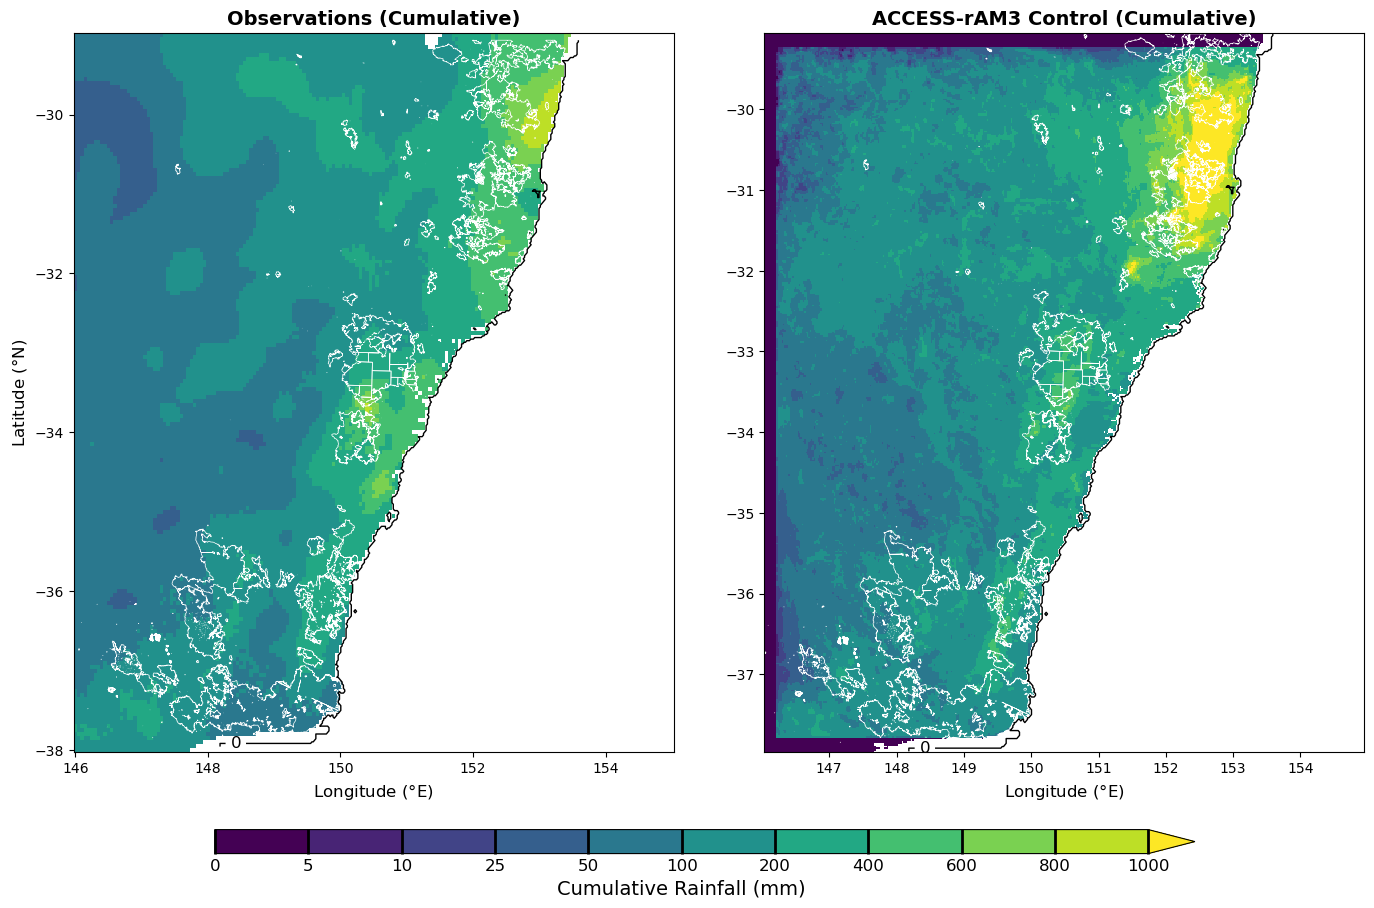

In [8]:
start_time = "2020-01-14"
end_time   = "2020-02-13"
levels = [0, 5, 10, 25, 50, 100, 200, 400, 600, 800, 1000]

fig, axes = plt.subplots(1, 2, figsize=(14,8), constrained_layout=True)

#------control cumulative rainfal----
start_time_shift = pd.Timestamp(start_time) - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
end_time_shift   = pd.Timestamp(end_time) + pd.Timedelta(hours=8)

hourly_model = control.sel(time=slice(start_time_shift, end_time_shift)) * 3600  # mm/s → mm/hr
cumulative_model = hourly_model.sum(dim="time", skipna=True)
cumulative_model = cumulative_model.where(landmask == 1)  # mask oceans

im0 = cumulative_model.plot(
    ax=axes[1],
    cmap="viridis",
    levels=levels,
    extend="max",
    add_colorbar=False
)

fires_clipped.boundary.plot(ax=axes[1], edgecolor="white", linewidth=0.5)
contours = sa1.plot.contour(ax=axes[1], levels=[0], colors="black", linewidths=1, add_colorbar=False)
axes[1].clabel(contours, fmt="%d", fontsize=12)
axes[1].set_title("ACCESS-rAM3 Control (Cumulative)", weight = 'bold', fontsize = 14)

#------AGCD cumulative rainfall-----
cumulative_agcd = AGCD.sum(dim="time", skipna=True)
cumulative_agcd = cumulative_agcd.where(~AGCD.isnull().all(dim="time"))

im1 = cumulative_agcd.plot(
    ax=axes[0],
    cmap="viridis",
    levels=levels,
    extend="max",
    add_colorbar=False
)

fires_clipped.boundary.plot(ax=axes[0], edgecolor="white", linewidth=0.5)
contours = sa1.plot.contour(ax=axes[0], levels=[0], colors="black", linewidths=1, add_colorbar=False)
axes[0].clabel(contours, fmt="%d", fontsize=12)
axes[0].set_title("Observations (Cumulative)", weight = 'bold', fontsize = 14)

axes[0].set_xlabel("Longitude ($\\degree$E)", fontsize = 12)
axes[0].set_ylabel("Latitude ($\\degree$N)", fontsize = 12)
axes[1].set_xlabel("Longitude ($\\degree$E)", fontsize = 12)
axes[1].set_ylabel("")  #no label on right panel

cax = fig.add_axes([0.15, -0.06, 0.7, 0.03]) 

cbar = fig.colorbar(
    im1,
    cax=cax,
    orientation="horizontal"
)
cbar.set_label("Cumulative Rainfall (mm)", fontsize=14)
cbar.ax.tick_params(axis="x", width=2, direction="in", length=18, labelsize=12)
cbar.set_ticks(levels)

# fig.savefig("/g/data/ng72/as9583/new_analysis/figures/model_validation_cumulative.png", dpi=300, bbox_inches="tight")

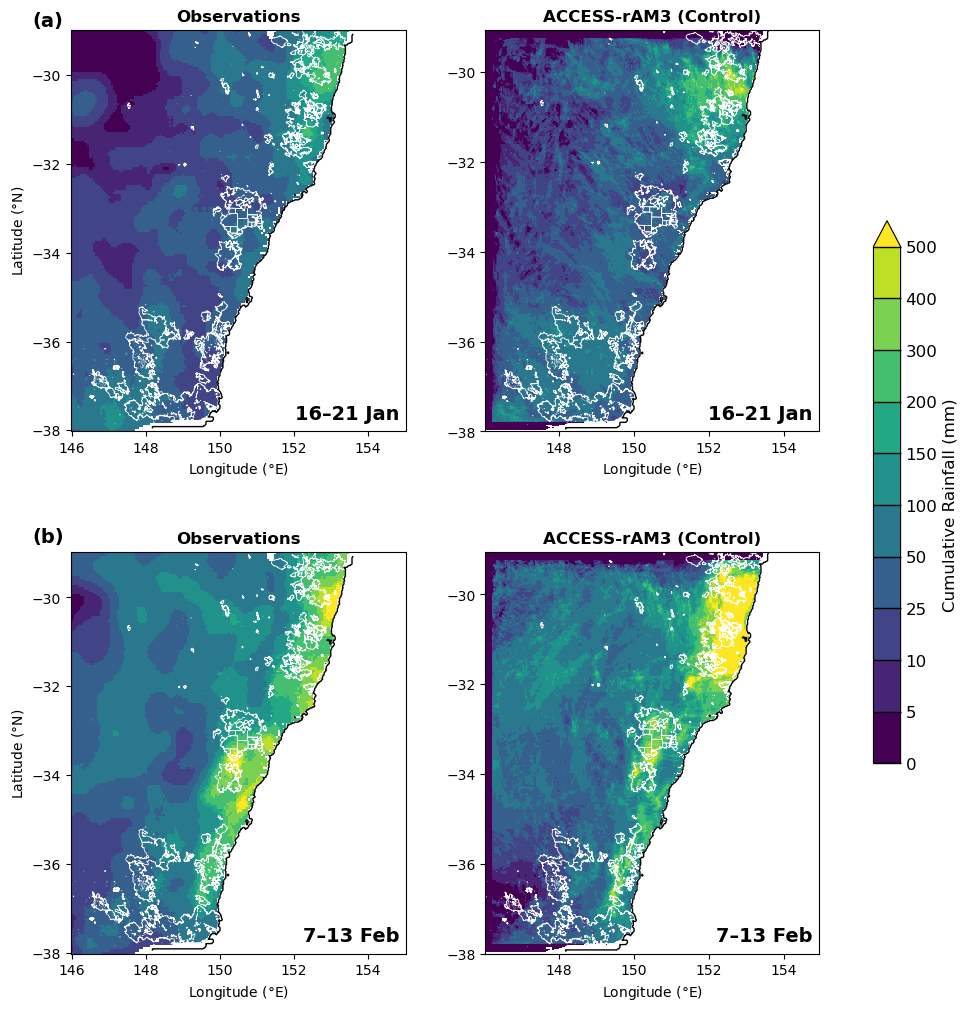

In [9]:
#periods
periods = [
    ("2020-01-16", "2020-01-21", "16–21 Jan"),
    ("2020-02-07", "2020-02-13", "7–13 Feb")
]

levels = [0, 5, 10, 25, 50, 100, 150, 200, 300, 400, 500]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.subplots_adjust(wspace=-0.3, hspace=0.3)

for i, (start_time, end_time, title) in enumerate(periods):
    
    #---shift model time to match AGCD---
    start_time_shift = pd.Timestamp(start_time) - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time_shift   = pd.Timestamp(end_time) + pd.Timedelta(hours=8)
    
    #---model---
    hourly_model = control.sel(time=slice(start_time_shift, end_time_shift)) * 3600  # mm/s → mm/hr
    period_model = hourly_model.sum(dim="time", skipna=True)
    period_model = period_model.where(landmask == 1)  # mask oceans

    #---obs---
    agcd_sel = AGCD.sel(time=slice(start_time, end_time))
    period_agcd = agcd_sel.sum(dim="time", skipna=True)
    period_agcd = period_agcd.where(~agcd_sel.isnull().all(dim="time"))

    #----obs-----
    im_agcd = period_agcd.plot(
        ax=axes[i,0],
        cmap="viridis",
        levels=levels,
        extend="max",
        add_colorbar=False
    )
    fires.boundary.plot(ax=axes[i,0], edgecolor="white", linewidth=0.5)
    sa1.plot.contour(ax=axes[i,0], levels=[0], colors="black", linewidths=1, add_colorbar=False)
    axes[i,0].set_title("Observations", weight="bold")
    axes[i,0].set_xlabel("Longitude ($\\degree$E)")
    axes[i,0].set_ylabel("Latitude ($\\degree$N)")
    axes[i,0].text(
        0.98, 0.02,
        title,
        transform=axes[i,0].transAxes,
        ha="right", va="bottom",
        fontsize=14, color="black", weight="bold"
    )

    #---model----
    im_model = period_model.plot(
        ax=axes[i,1],
        cmap="viridis",
        levels=levels,
        extend="max",
        add_colorbar=False
    )
    fires.boundary.plot(ax=axes[i,1], edgecolor="white", linewidth=0.5)
    sa1.plot.contour(ax=axes[i,1], levels=[0], colors="black", linewidths=1, add_colorbar=False)
    axes[i,1].set_title("ACCESS-rAM3 (Control)", weight="bold")
    axes[i,1].set_xlabel("Longitude ($\\degree$E)")
    axes[i,1].set_ylabel("Latitude ($\\degree$N)")
    axes[i,1].text(
        0.98, 0.02,
        title,
        transform=axes[i,1].transAxes,
        ha="right", va="bottom",
        fontsize=14, color="black", weight="bold"
    )

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

for ax in [axes[0,1], axes[1,1]]:
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[::2])

#cbar
cbar = fig.colorbar(im_agcd, ax=axes, orientation="vertical", fraction=0.025, shrink=0.6, pad=0.05)
cbar.set_label("Cumulative Rainfall (mm)", fontsize=12)
cbar.ax.tick_params(axis="y", width=1, direction="in", length=20, labelsize=12)
cbar.set_ticks(levels)

fig.text(0.28, 0.895, "(a)", fontsize=14, fontweight="bold", va="top", ha="left")
fig.text(0.28, 0.465, "(b)", fontsize=14, fontweight="bold", va="top", ha="left")

plt.show()

# fig.savefig("/g/data/ng72/as9583/new_analysis/figures/period_cumulative.png", dpi=300, bbox_inches="tight")

## 90%

In [32]:
#cumulative 90% range
if 'lat' in cumulative_agcd.dims and 'latitude' in cumulative_model.dims:
    cumulative_agcd = cumulative_agcd.rename({'lat': 'latitude', 'lon': 'longitude'})

#regrid model to match AGCD
cumulative_model_rg = cumulative_model.interp(
    latitude=cumulative_agcd.latitude,
    longitude=cumulative_agcd.longitude
)

#difference (model - obs)
diff = cumulative_model_rg - cumulative_agcd

p95_diff = np.nanpercentile(diff, 95)
p5_diff = np.nanpercentile(diff, 5)

print(f"95th percentile of model–observation difference: {p95_diff:.2f} mm")
print(f"5th percentile of model–observation difference: {p5_diff:.2f} mm")


95th percentile of model–observation difference: 228.42 mm
5th percentile of model–observation difference: -156.97 mm


In [34]:
##90% diffs over events
periods = [
    ("2020-01-16", "2020-01-21", "16–21 Jan"),
    ("2020-02-07", "2020-02-13", "7–13 Feb")
]

cumulative_model_periods = {}
cumulative_agcd_periods = {}

#regrid
for start_time, end_time, title in periods:
    start_shift = pd.Timestamp(start_time) - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_shift   = pd.Timestamp(end_time) + pd.Timedelta(hours=8)
    
    #model
    hourly_model = control.sel(time=slice(start_shift, end_shift)) * 3600
    period_model = hourly_model.sum(dim="time", skipna=True).where(landmask == 1)
    
    #regrid
    period_model_regrid = period_model.rename({'latitude': 'lat', 'longitude': 'lon'}) \
                                   .interp(lat=AGCD.lat, lon=AGCD.lon)
    
    #obs
    agcd_sel = AGCD.sel(time=slice(start_time, end_time))
    period_agcd = agcd_sel.sum(dim="time", skipna=True)
    period_agcd = period_agcd.where(~agcd_sel.isnull().all(dim="time"))  # remove fully missing
    
    cumulative_model_periods[title] = period_model_regrid
    cumulative_agcd_periods[title] = period_agcd

#diffs and percentiles
for title in cumulative_model_periods.keys():
    model = cumulative_model_periods[title]
    obs   = cumulative_agcd_periods[title]
    
    diff = model - obs
    
    #Drop NaNs
    diff_valid = diff.where(~np.isnan(diff), drop=True)
    
    p95 = np.nanpercentile(diff_valid, 95)
    p5  = np.nanpercentile(diff_valid, 5)
    print(f"{title} -> 95th percentile diff: {p95:.2f} mm, 5th percentile diff: {p5:.2f} mm")


16–21 Jan -> 95th percentile diff: 79.30 mm, 5th percentile diff: -42.22 mm
7–13 Feb -> 95th percentile diff: 180.26 mm, 5th percentile diff: -94.87 mm
